# Notebook 01: Data Loading & Quality Control

**Objective**: Learn to load single-cell data and perform basic quality control.

## What you will learn:
- Load 10X Genomics data
- Calculate quality control (QC) metrics
- Visualize distributions
- Filter low-quality cells and genes

## Dataset used:
- **PBMC 3k**: 3000 Peripheral Blood Mononuclear Cells
- Source: 10X Genomics

In [2]:
# Import necessary libraries
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure Scanpy
sc.settings.verbosity = 3  # Verbosity level (0=errors, 1=warnings, 2=info, 3=hints)
sc.settings.set_figure_params(dpi=80, facecolor='white')

# Define paths
import os
data_dir = '../data/'
results_dir = '../results/'

# Create directories if they don't exist
os.makedirs(data_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

print(f"Scanpy version: {sc.__version__}")

Scanpy version: 1.11.4


## 1. Loading Data

Scanpy can load data from multiple formats:
- **10X Genomics**: Standard format for single-cell data
- **H5AD**: Scanpy's native format (AnnData)
- **CSV/TSV**: Count matrices

We will automatically download the PBMC 3k dataset.

In [3]:
# Download and load the PBMC 3k dataset
# This function automatically downloads the data if not present
adata = sc.datasets.pbmc3k()

print(f"Data dimensions: {adata.shape[0]} cells × {adata.shape[1]} genes")
print(f"Memory size: {adata.X.data.nbytes / 1e6:.2f} MB")

try downloading from url
https://falexwolf.de/data/pbmc3k_raw.h5ad
... this may take a while but only happens once


  0%|          | 0.00/5.58M [00:00<?, ?B/s]

Data dimensions: 2700 cells × 32738 genes
Memory size: 9.15 MB


## 2. AnnData Structure

`AnnData` is Scanpy's main data structure. It contains:

- **`.X`**: Count matrix (cells × genes)
- **`.obs`**: Cell metadata (rows)
- **`.var`**: Gene metadata (columns)
- **`.uns`**: Unstructured data (parameters, etc.)
- **`.obsm`**: Multidimensional matrices (PCA, UMAP, etc.)
- **`.layers`**: Alternative data layers (raw counts, normalized, etc.)

In [6]:
# Explore data structure
print("=" * 30)
print("DATA STRUCTURE")
print("=" * 30)
print(adata)
print("\n" + "=" * 60)
print("CELL OVERVIEW (obs)")
print("=" * 60)
print(adata.obs.head())
print("\n" + "=" * 60)
print("GENE OVERVIEW (var)")
print("=" * 60)
print(adata.var.head())

DATA STRUCTURE
AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

CELL OVERVIEW (obs)
Empty DataFrame
Columns: []
Index: [AAACATACAACCAC-1, AAACATTGAGCTAC-1, AAACATTGATCAGC-1, AAACCGTGCTTCCG-1, AAACCGTGTATGCG-1]

GENE OVERVIEW (var)
                     gene_ids
index                        
MIR1302-10    ENSG00000243485
FAM138A       ENSG00000237613
OR4F5         ENSG00000186092
RP11-34P13.7  ENSG00000238009
RP11-34P13.8  ENSG00000239945


## 3. Calculate Quality Control (QC) Metrics

Important QC metrics:

1. **Number of genes detected per cell**: Cells with too few genes = dead/empty cells
2. **Total UMI counts per cell**: Indicator of sequencing depth
3. **Percentage of mitochondrial genes**: Cells with high mito % = stressed/dying cells

**Why mitochondrial genes?**
- Dying cells lose their cytoplasm but retain mitochondria
- High % of mito genes indicates poor quality cells

In [7]:
# Identify mitochondrial genes
# In humans, mitochondrial genes start with "MT-"
adata.var['mt'] = adata.var_names.str.startswith('MT-')

# Calculate QC metrics
sc.pp.calculate_qc_metrics(
    adata,
    qc_vars=['mt'],  # Variables to track
    percent_top=None,
    log1p=False,
    inplace=True
)

# Display the new columns added to obs (cells)
print("New QC metrics in adata.obs:")
print(adata.obs.columns.tolist())
print("\n" + "=" * 60)
print("QC Metrics Summary:")
print("=" * 60)
print(adata.obs[['n_genes_by_counts', 'total_counts', 'pct_counts_mt']].describe())

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


New QC metrics in adata.obs:
['n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt']

QC Metrics Summary:
       n_genes_by_counts  total_counts  pct_counts_mt
count        2700.000000   2700.000000    2700.000000
mean          846.994074   2366.900391       2.215132
std           282.104964   1094.262085       1.165438
min           212.000000    548.000000       0.000000
25%           690.000000   1757.750000       1.536238
50%           817.000000   2197.000000       2.029639
75%           953.250000   2763.000000       2.640218
max          3422.000000  15844.000000      22.569027


## 4. Visualize QC Metrics

Let's visualize the distributions to identify thresholds for filtering.

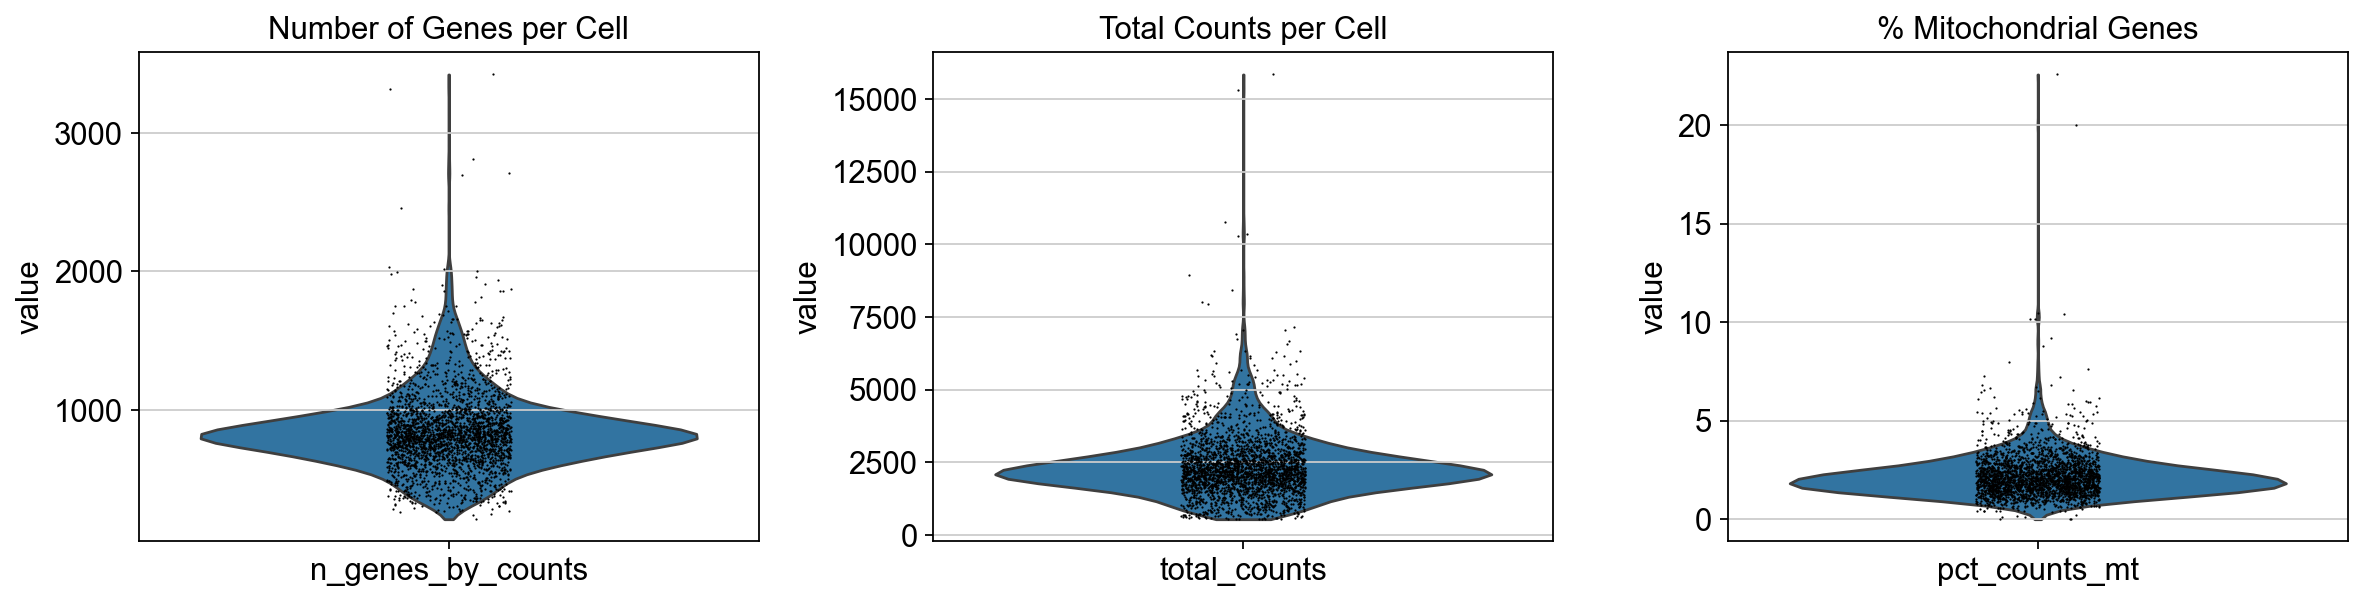

In [8]:
# Create violin plots for QC metrics
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Number of genes per cell
sc.pl.violin(adata, 'n_genes_by_counts', ax=axes[0], show=False)
axes[0].set_title('Number of Genes per Cell')

# Plot 2: Total counts per cell
sc.pl.violin(adata, 'total_counts', ax=axes[1], show=False)
axes[1].set_title('Total Counts per Cell')

# Plot 3: Percentage of mitochondrial genes
sc.pl.violin(adata, 'pct_counts_mt', ax=axes[2], show=False)
axes[2].set_title('% Mitochondrial Genes')

plt.tight_layout()
plt.savefig(f'{results_dir}01_qc_violin_plots.png', dpi=150, bbox_inches='tight')
plt.show()

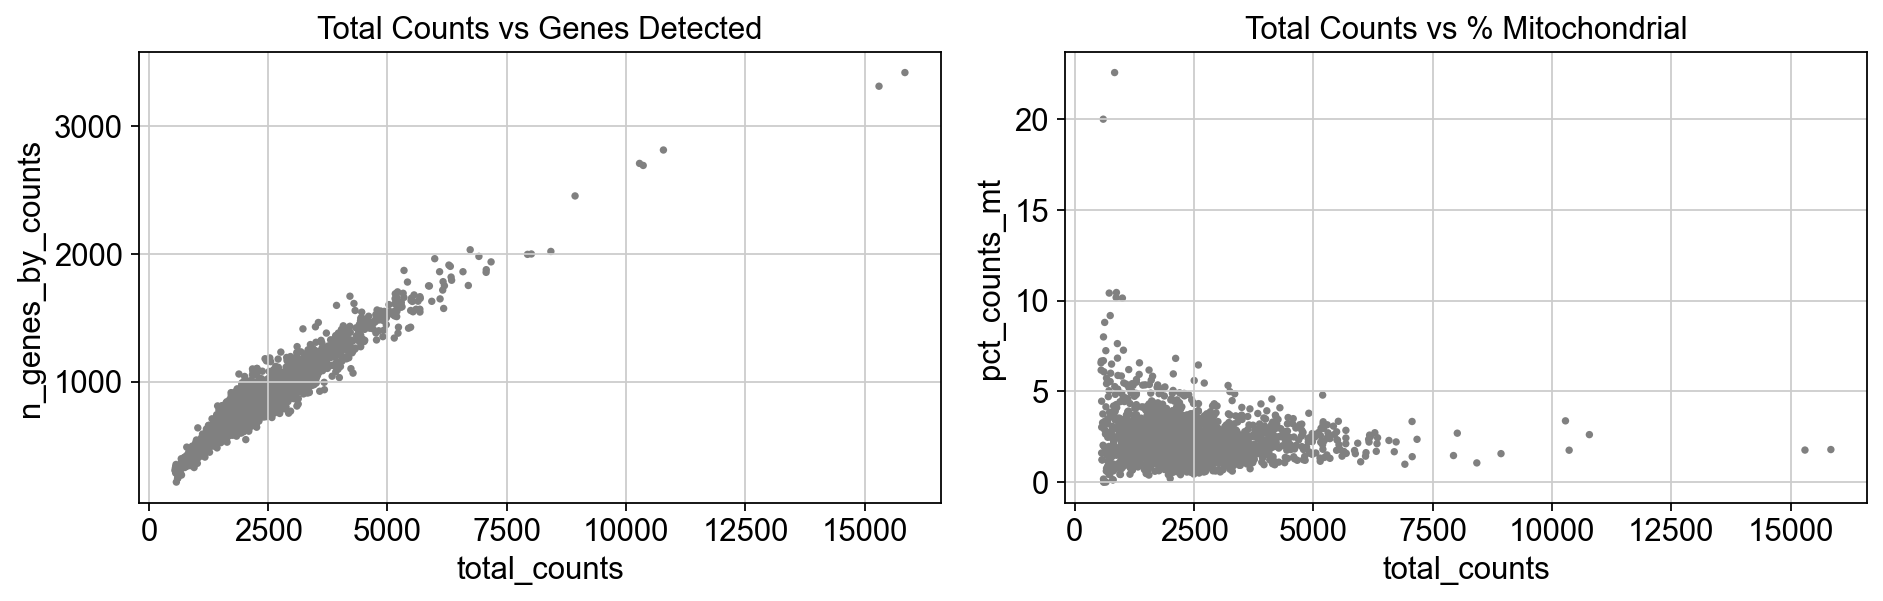

In [9]:
# Scatter plots to see relationships between metrics
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot 1: Total counts vs genes detected
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', ax=axes[0], show=False)
axes[0].set_title('Total Counts vs Genes Detected')

# Plot 2: Total counts vs % mitochondrial
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', ax=axes[1], show=False)
axes[1].set_title('Total Counts vs % Mitochondrial')

plt.tight_layout()
plt.savefig(f'{results_dir}01_qc_scatter_plots.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Filter Cells Based on QC Metrics

### Understanding Our Data Distribution

From our QC metrics summary:
- **n_genes_by_counts**: mean = 847, range = [212 - 3422]
- **total_counts**: mean = 2367, range = [548 - 15,844]
- **pct_counts_mt**: mean = 2.2%, 75th percentile = 2.6%, max = 22.6%

### Setting Filtering Thresholds

We need to remove:
1. **Empty droplets**: Very few genes detected (< 200 genes)
2. **Doublets**: Two cells captured together (unusually high gene counts > 2500)
3. **Dying/stressed cells**: High mitochondrial content (> 10%)

### Why These Specific Thresholds?

#### **Minimum genes per cell: 200**
- Cells with < 200 genes are likely empty droplets or debris
- Our minimum is 212, so this removes only extreme outliers

#### **Maximum genes per cell: 2500**
- Normal cells: 500-1500 genes typically
- Our 75th percentile: 953 genes
- Cells with > 2500 genes are likely doublets (two cells stuck together)
- Our max is 3422, so this will catch potential doublets

#### **Maximum % mitochondrial: 10%**
- **Why mitochondrial genes matter**: Dying cells lose cytoplasm but retain mitochondria
- **Our data**: mean = 2.2%, 75th percentile = 2.6%
- **Why 10% instead of 5%?**
  - 5% would be very strict (only 2× the 75th percentile)
  - 10% is more permissive: keeps slightly stressed but viable cells
  - Still removes clearly dying cells (like those at 22.6%)
  
### Balancing Strictness vs. Data Loss

**Strict filtering (e.g., 5% mito)**:
- Very clean data
- May lose viable cells
- Reduces statistical power

**Permissive filtering (e.g., 10% mito)**:
- Keeps more cells for analysis
- Still removes clearly bad cells
- Slightly noisier data (acceptable trade-off)

### General Rule

**Always adjust thresholds based on**:
- Visual inspection of QC plots (violin plots, scatter plots)
- Tissue type (some tissues naturally have higher mito %)
- Sample quality (fresh vs frozen samples)
- Biological context (stressed tissues may have higher mito %)

**Our choice**: We use **10% mitochondrial threshold** as a balanced approach for this PBMC dataset.

In [10]:
# Print statistics before filtering
print("=" * 60)
print("BEFORE FILTERING")
print("=" * 60)
print(f"Number of cells: {adata.n_obs}")
print(f"Number of genes: {adata.n_vars}")

# Filter cells based on QC metrics
adata = adata[adata.obs.n_genes_by_counts < 2500, :]  # Remove potential doublets
adata = adata[adata.obs.n_genes_by_counts > 200, :]   # Remove empty droplets
adata = adata[adata.obs.pct_counts_mt < 10, :]        # Remove dying cells (10% threshold)

print("\n" + "=" * 60)
print("AFTER FILTERING")
print("=" * 60)
print(f"Number of cells: {adata.n_obs}")
print(f"Number of genes: {adata.n_vars}")
print(f"Cells removed: {2700 - adata.n_obs}")
print(f"Percentage of cells kept: {100 * adata.n_obs / 2700:.1f}%")

BEFORE FILTERING
Number of cells: 2700
Number of genes: 32738

AFTER FILTERING
Number of cells: 2689
Number of genes: 32738
Cells removed: 11
Percentage of cells kept: 99.6%


## 6. Filter Genes

Remove genes that are detected in very few cells (likely noise or technical artifacts).

**Threshold**: Keep genes expressed in at least 3 cells

**Why?**
- Genes detected in only 1-2 cells are often sequencing errors
- They add noise without biological signal
- Removing them reduces computational burden

In [12]:
# Print statistics before gene filtering
print("=" * 60)
print("BEFORE GENE FILTERING")
print("=" * 60)
print(f"Number of genes: {adata.n_vars}")

# Filter genes expressed in fewer than 3 cells
sc.pp.filter_genes(adata, min_cells=3)

print("\n" + "=" * 60)
print("AFTER GENE FILTERING")
print("=" * 60)
print(f"Number of genes: {adata.n_vars}")
print(f"Genes removed: {32738 - adata.n_vars}")
print(f"Percentage of genes kept: {100 * adata.n_vars / 32738:.1f}%")

BEFORE GENE FILTERING
Number of genes: 32738
filtered out 19067 genes that are detected in less than 3 cells

AFTER GENE FILTERING
Number of genes: 13671
Genes removed: 19067
Percentage of genes kept: 41.8%


/Users/utilisateur1/Documents/GitHub/Hands-on-Scanpy/venv/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


## 7. Visualize Filtered Data

Let's see how our QC metrics look after filtering.

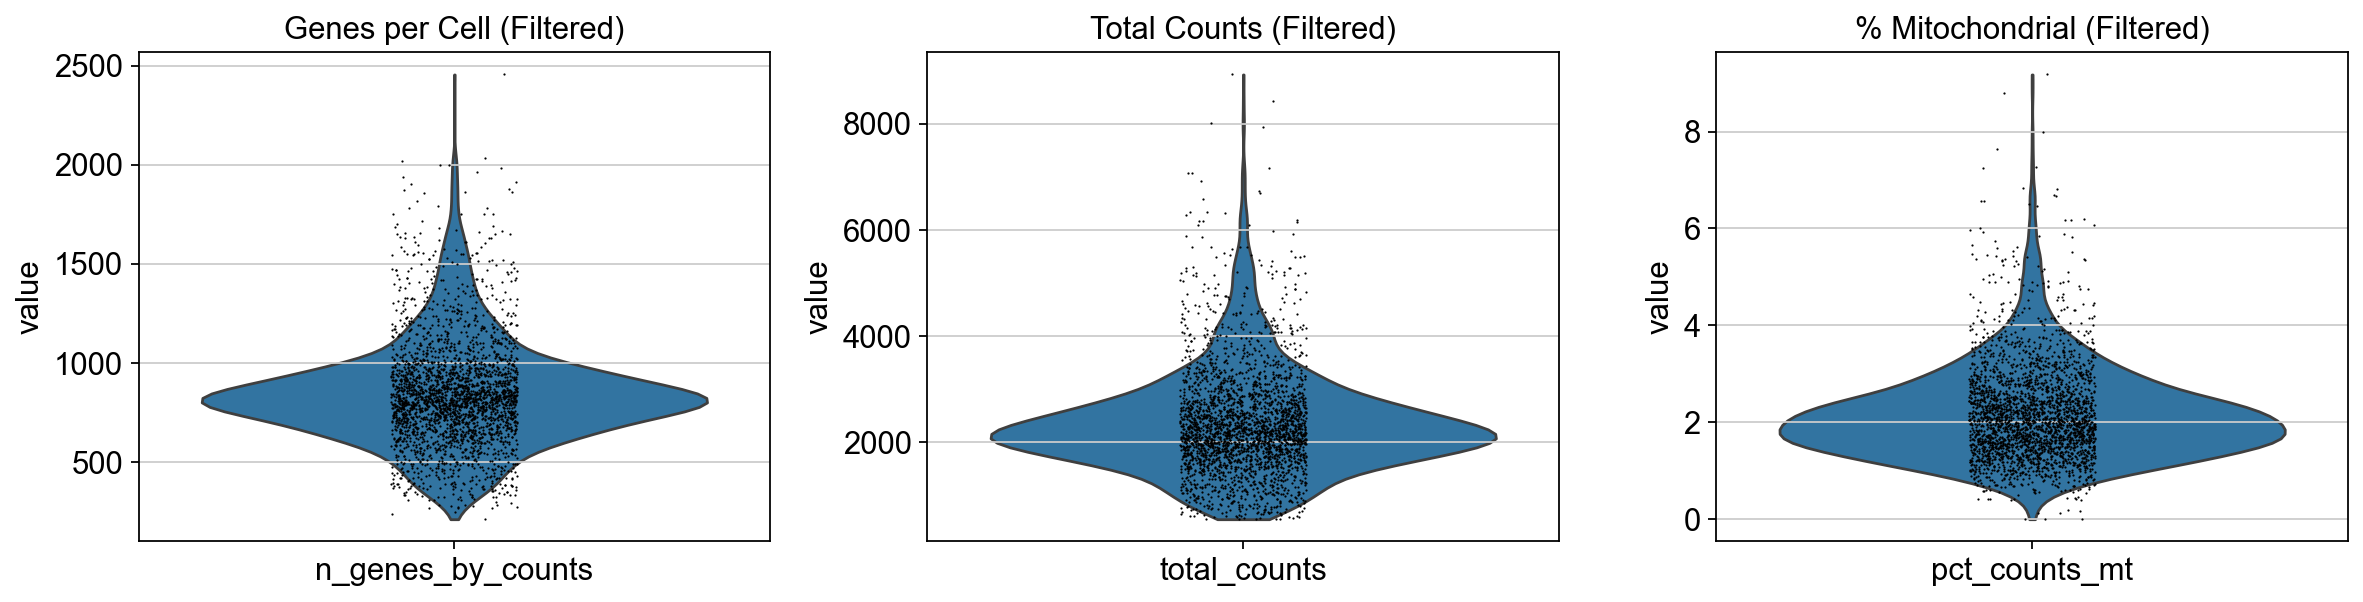

Filtered QC plots saved!


In [13]:
# Visualize QC metrics after filtering
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

sc.pl.violin(adata, 'n_genes_by_counts', ax=axes[0], show=False)
axes[0].set_title('Genes per Cell (Filtered)')

sc.pl.violin(adata, 'total_counts', ax=axes[1], show=False)
axes[1].set_title('Total Counts (Filtered)')

sc.pl.violin(adata, 'pct_counts_mt', ax=axes[2], show=False)
axes[2].set_title('% Mitochondrial (Filtered)')

plt.tight_layout()
plt.savefig(f'{results_dir}01_qc_violin_plots_filtered.png', dpi=150, bbox_inches='tight')
plt.show()

print("Filtered QC plots saved!")

## 8. Save Filtered Data

Save the filtered data for use in the next notebook.

The `.h5ad` format is Scanpy's native format:
- Efficient storage
- Preserves all metadata
- Fast loading

In [15]:
# Save the filtered data
adata.write(f'{data_dir}pbmc3k_filtered.h5ad')

print("Filtered data saved to:", f'{data_dir}pbmc3k_filtered.h5ad')
print(f"Final dimensions: {adata.shape[0]} cells × {adata.shape[1]} genes")

Filtered data saved to: ../data/pbmc3k_filtered.h5ad
Final dimensions: 2689 cells × 13671 genes


## 📋 Summary & Results

### What we accomplished:

1. **Loaded PBMC 3k dataset**
   - Initial: 2,700 cells × 32,738 genes
   - Source: 10X Genomics public dataset

2. **Calculated QC metrics**
   - Number of genes per cell
   - Total UMI counts per cell
   - Percentage of mitochondrial genes

3. **Visualized distributions**
   - Violin plots to identify outliers
   - Scatter plots to see relationships between metrics

4. **Applied data-driven filtering thresholds**
   - **Cells**: Removed 11 cells (0.4%) - excellent quality!
     - Min genes: 200 (remove empty droplets)
     - Max genes: 2,500 (remove doublets)
     - Max mito %: 10% (remove dying cells)
   - **Genes**: Removed 19,067 genes (58.2%)
     - Kept only genes expressed in ≥3 cells

5. **Saved clean dataset**
   - File: `data/pbmc3k_filtered.h5ad`
   - Ready for downstream analysis

---

### Final Dataset Quality

| Metric | Before | After | Change |
|--------|--------|-------|--------|
| **Cells** | 2,700 | **2,689** | -11 (-0.4%)|
| **Genes** | 32,738 | **13,671** | -19,067 (-58.2%)|

**Final dimensions: 2,689 high-quality cells × 13,671 reliably detected genes**

---

### Data Quality Assessment

**Excellent cell retention (99.6%)**: Indicates high-quality sample preparation  
**Appropriate gene filtering**: Removed noisy/rare genes while keeping informative ones  
**Low mitochondrial content (mean 2.2%)**: Healthy, viable cells  
**Consistent gene counts**: Minimal doublets detected  

---

### Next Steps: Notebook 02 - Preprocessing & Normalization

In the next notebook, we will:

1. **Normalize counts** - Account for sequencing depth differences between cells
2. **Log transformation** - Stabilize variance across expression levels
3. **Identify highly variable genes** - Find genes with biological variation
4. **Scale data** - Prepare for dimensionality reduction

**Why normalization matters:**
- Different cells have different total counts (sequencing depth)
- We need to make cells comparable before analysis
- Normalization removes technical variation while preserving biological signal

---

**🎉 Congratulations! You've completed quality control and have a clean dataset ready for analysis!**

**Next:** Open `notebooks/02_preprocessing_normalization.ipynb`